In [1]:
import fcwt
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import signal
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
import torch.nn as nn
from vit_pytorch import ViT
from scipy.ndimage import zoom

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# load dataset
x = pickle.load(open('data_preprocessed_python/s01.dat', 'rb'), encoding='latin1')
data = x['data']
labels = x['labels']

relevant_channels = data[:, :32, :]
relevant_labels = labels[:, :2]

In [3]:
print(relevant_labels)
print(relevant_labels.shape)

[[7.71 7.6 ]
 [8.1  7.31]
 [8.58 7.54]
 [4.94 6.01]
 [6.96 3.92]
 [8.27 3.92]
 [7.44 3.73]
 [7.32 2.55]
 [4.04 3.29]
 [1.99 4.86]
 [2.99 2.36]
 [2.71 2.77]
 [1.95 3.12]
 [4.18 2.24]
 [3.17 8.08]
 [6.81 7.44]
 [2.46 6.91]
 [7.23 7.15]
 [7.17 8.  ]
 [8.26 7.91]
 [9.   7.95]
 [7.09 2.08]
 [8.15 3.01]
 [7.04 7.09]
 [8.86 7.21]
 [7.28 7.27]
 [7.35 6.95]
 [3.88 3.35]
 [1.36 2.27]
 [2.08 2.99]
 [3.03 8.14]
 [2.28 8.  ]
 [3.81 3.85]
 [2.28 7.09]
 [2.06 8.15]
 [2.9  6.92]
 [2.31 6.88]
 [3.33 7.18]
 [3.24 6.18]
 [5.1  7.12]]
(40, 2)


In [4]:
# initialize constant variables
# paramaters for calculating cwt, not to be changed
fs = 128
f0 = 4
f1 = 45
fn = 252

# parameters for model training etc., may be changed to adjust balance between performance and cost
# TODO: consider evolutionary approach to finding optimal parameters
BATCH_SIZE = 1
IMAGE_SIZE = 2048
PATCH_SIZE = 128

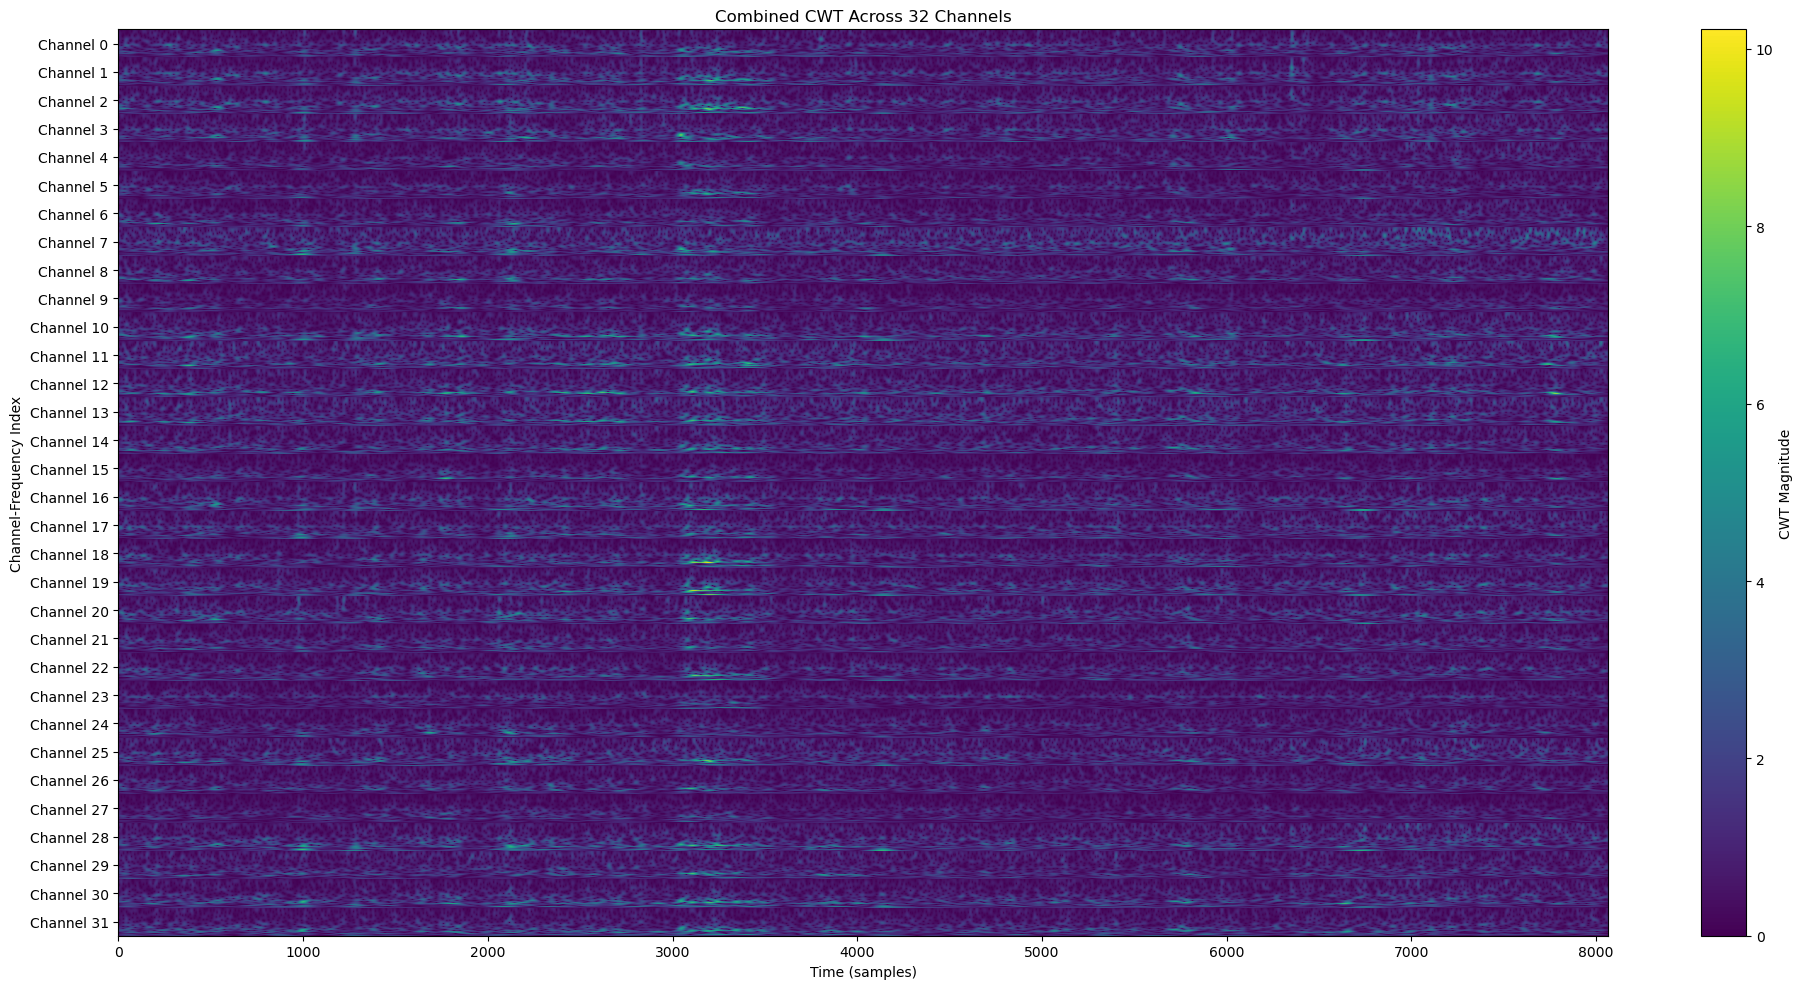

In [4]:
# plot CWT for all channels in one trial
fs = 128
f0 = 4
f1 = 45
fn = 252
total_cwt = np.zeros((8064, 8064))

for channel in range(32):    
    signal = relevant_channels[0][channel]
    _, current_cwt = fcwt.cwt(signal, fs, f0, f1, fn)
    start = channel * fn
    end = (channel + 1) * fn
    total_cwt[start:end, :] = abs(current_cwt)

# plotting cwt data for example visualization
plt.figure(figsize=(20, 10))
plt.imshow(
    total_cwt,
    aspect='auto',
    cmap='viridis',
    vmin=0,
    interpolation='nearest'
)

plt.colorbar(label='CWT Magnitude')
plt.xlabel('Time (samples)')
plt.ylabel('Channel-Frequency Index')
yticks = np.arange(0, 32 * fn, fn)
plt.yticks(
    yticks + fn/2,  # Center labels between channel blocks
    [f'Channel {i}' for i in range(32)]
)

plt.title('Combined CWT Across 32 Channels')
plt.tight_layout()
plt.show()


In [ ]:
# saving image as an example
cwt_min = np.min(total_cwt)
cwt_max = np.max(total_cwt)
normalized = (total_cwt - cwt_min) / (cwt_max - cwt_min) * 255
normalized = normalized.astype(np.uint8)  
image = Image.fromarray(normalized, mode='L')
image.save("cwt_raw_image.png")

In [5]:
# sanity check with a dataframe object
cwt_df = pd.DataFrame(total_cwt)
print(cwt_df.dtypes)
cwt_df

0       float64
1       float64
2       float64
3       float64
4       float64
         ...   
8059    float64
8060    float64
8061    float64
8062    float64
8063    float64
Length: 8064, dtype: object


,0,1,2,3,4,5,6,7,8,9,...,8054,8055,8056,8057,8058,8059,8060,8061,8062,8063
0,0.245679,0.278311,0.307119,0.330224,0.346066,0.353569,0.352242,0.342213,0.324161,0.299202,...,0.429833,0.419672,0.405866,0.388510,0.367923,0.344732,0.319853,0.294364,0.269282,0.245324
1,0.247645,0.281022,0.310689,0.334736,0.351550,0.359988,0.359485,0.350092,0.332425,0.307556,...,0.441500,0.429286,0.413153,0.393341,0.370321,0.344864,0.318018,0.290968,0.264807,0.240288
2,0.250519,0.284569,0.315013,0.339912,0.357604,0.366883,0.367114,0.358276,0.340926,0.316095,...,0.453058,0.438772,0.420342,0.398155,0.372830,0.345277,0.316657,0.288242,0.261175,0.236216
3,0.252264,0.287100,0.318453,0.344347,0.363068,0.373343,0.374461,0.366328,0.349441,0.324789,...,0.464398,0.447930,0.427082,0.402386,0.374609,0.344804,0.314262,0.284361,0.256322,0.230932
4,0.254478,0.290091,0.322330,0.349189,0.368905,0.380144,0.382127,0.374690,0.358267,0.333808,...,0.475013,0.456390,0.433199,0.406115,0.376048,0.344177,0.311902,0.280684,0.251802,0.226059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8059,0.859771,0.876020,0.892384,0.908858,0.925435,0.942109,0.958872,0.975718,0.992638,1.009628,...,0.305094,0.300206,0.295285,0.290339,0.285375,0.280399,0.275418,0.270440,0.265470,0.260516
8060,0.661105,0.674458,0.687937,0.701537,0.715253,0.729081,0.743015,0.757051,0.771181,0.785402,...,0.290127,0.285699,0.281240,0.276754,0.272246,0.267719,0.263178,0.258625,0.254066,0.249504
8061,0.480287,0.491079,0.501998,0.513040,0.524202,0.535479,0.546867,0.558361,0.569957,0.581649,...,0.284556,0.279659,0.274739,0.269795,0.264832,0.259849,0.254849,0.249835,0.244807,0.239769
8062,0.343268,0.352163,0.361160,0.370257,0.379449,0.388732,0.398100,0.407550,0.417078,0.426678,...,0.303887,0.299509,0.295133,0.290761,0.286394,0.282034,0.277684,0.273345,0.269018,0.264706


In [12]:
class CWTDataset(Dataset):
    def __init__(self, images, labels, device="cpu"):
        self.images = torch.tensor(np.array(images), dtype=torch.float32).unsqueeze(1).to(device)
        self.labels = torch.tensor(labels, dtype=torch.long).to(device)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return self.images[index], self.labels[index]

In [14]:
classes = []
for trial in range(40):
    # 4 valence-arousal classes
    valence, arousal = relevant_labels[trial][0], relevant_labels[trial][1]
    cls = 0 if valence < 4.5 and arousal < 4.5 else \
                    1 if valence < 4.5 else \
                    2 if arousal < 4.5 else 3
    classes.append(cls)

# getting cwt data for each trial
all_cwts = []
for trial in range(40):
    current_full_cwt = np.zeros((8064, 8064))
    
    for channel in range(32): # getting cwt from each channel
        signal = relevant_channels[trial, channel, :]
        _, cwt = fcwt.cwt(signal, fs, f0, f1, fn)
        start = channel * fn
        end = (channel + 1) * fn
        current_full_cwt[start:end, :] = abs(cwt)

    #downsample raw image
    factor = 8064 / IMAGE_SIZE
    downsampled_image = zoom(
        current_full_cwt,
        (1/factor, 1/factor),
        order=1,
    )
    all_cwts.append(downsampled_image)

print("all_cwts.shape: ", all_cwts)
print("classifications.shape: ", classes)
# initializing torch dataset object
train_images, test_images, train_labels, test_labels = train_test_split(
    all_cwts, classes, test_size=0.2, random_state=42
)
train_dataset = CWTDataset(train_images, train_labels, device=device)
test_dataset = CWTDataset(test_images, test_labels, device=device)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("train datum shape: ", train_dataset[0][0].shape)

# vision transformer model
vit = ViT(
    image_size=IMAGE_SIZE,
    patch_size=PATCH_SIZE,
    num_classes=4,
    dim=512,
    depth=6,
    heads=8,
    mlp_dim=2048,
    channels=1,
    dropout=0.2,
    emb_dropout=0.1,
    pool='mean'
).to(device)

all_cwts.shape:  [array([[0.24567924, 0.34509893, 0.32636528, ..., 0.4179862 , 0.343213  ,
        0.24532385],
       [0.25434251, 0.36734836, 0.35973742, ..., 0.45305832, 0.34225119,
        0.2263563 ],
       [0.26312512, 0.38917311, 0.39407207, ..., 0.48222407, 0.33471098,
        0.20192979],
       ...,
       [1.35423833, 1.45357534, 1.55263509, ..., 0.62983052, 0.57911623,
        0.53029797],
       [0.84763947, 0.9115985 , 0.97706928, ..., 0.29872231, 0.27932232,
        0.2598434 ],
       [0.27578542, 0.30494391, 0.33455202, ..., 0.30874854, 0.29516445,
        0.28156814]], shape=(2048, 2048)), array([[0.97720259, 1.09094831, 1.15152042, ..., 0.75714511, 1.01195603,
        0.99163324],
       [1.03534265, 1.19551891, 1.27524572, ..., 0.82585517, 1.0346009 ,
        0.97919902],
       [1.0822816 , 1.27667288, 1.371895  , ..., 0.89163811, 1.04568504,
        0.95752029],
       ...,
       [1.25028415, 1.29703901, 1.34085152, ..., 1.91809794, 1.78270457,
        1.6487741

In [ ]:
# train and test model on subject data
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=1e-4, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# training
print("Testing...")
for epoch in range(50):
    vit.train()
    for inputs, targets in train_loader:
        print(f"\tEpoch: {epoch}/50", end='\r')
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = vit(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
print("Training complete.")

# testing
vit.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = vit(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print("Testing complete.")
print(f"\tTest accuracy: {accuracy:.2f}%")


Testing...
Testing complete.
Testing complete.
Test accuracy: 25.00%


In [ ]:
# for subject in range(32): # uncomment to loop over all subjects
#     file_path = f"data_preprocessed_python/s{subject + 1:02}.dat"
#     x = pickle.load(open(file_path, 'rb'), encoding='latin1')
#     data = x['data']
#     labels = x['labels']
#     relevant_channels = data[:, :32, :]
#     relevant_labels = labels[:, :2]
#     subject_dependent_models = {}